In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress, validate_model, infer_model
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph, get_pos_init_graph, plot_graph, get_neighbors_graph

In [25]:
import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from scipy.spatial import Delaunay
import networkx as nx
import scipy.sparse as sp
import time
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportion_confint

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage, DigMontage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import Scaler

from torch_geometric.data import Data, InMemoryDataset

In [8]:
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os

In [23]:
import glob

DATA_PATH = '../processed_data/'

data = dict()
labels = dict()
for file in glob.glob(DATA_PATH + 'S*_P300_PZ.csv'):
    subj = file.split('/')[-1][:5]
    mat_data = np.loadtxt(file, delimiter=',')
    data[subj] = mat_data[:, 1:]
    labels[subj] = mat_data[:, 0]
    positive_samples = data[subj][labels[subj] == 1]
    positive_labels = labels[subj][labels[subj] == 1]
    temp_data = [data[subj]]
    temp_labels = [labels[subj]]
    for i in range(15):
        temp_data.append(positive_samples)
        temp_labels.append(positive_labels)
    data[subj] = np.vstack(temp_data)
    labels[subj] = np.hstack(temp_labels)

In [24]:
min_len = min(arr.shape[0] for arr in labels.values())

for subj in data.keys():
    permutation = torch.randperm(min_len)
    data[subj] = torch.tensor(data[subj][:min_len]).unsqueeze(1).float()[permutation]
    labels[subj] = torch.tensor(labels[subj].squeeze()[:min_len])[permutation]

In [27]:
all_train_data = []
all_train_labels = []
all_val_data = []
all_val_labels = []

for subj in data.keys():
    train_data, val_data, train_labels, val_labels = train_test_split(
        data[subj], 
        labels[subj], 
        test_size=0.15,
        shuffle=False
    )
    all_train_data.append(train_data)
    all_train_labels.append(train_labels)
    all_val_data.append(val_data)
    all_val_labels.append(val_labels)

train_dataset = CNNMatrixDataset(tensors=(torch.cat(all_train_data, 0), torch.cat(all_train_labels)), with_target=True, transform=None)
val_dataset = CNNMatrixDataset(tensors=(torch.cat(all_val_data, 0), torch.cat(all_val_labels)), with_target=True, transform=None)
all_dataloader = dict()
all_dataloader['train'] = DataLoader(train_dataset, batch_size=1024, shuffle=True)
all_dataloader['val'] = DataLoader(val_dataset, batch_size=1024, shuffle=True)

/home/leonid/Projects/multi_eeg/notebooks/../src/models_cnn.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.sig(self.linear_output(x))


Training complete in 5m 36s
accuracy:  0.6001540041067762
f1-score:  0.6018911321236903
S2001 accuracy CI: [0.593, 0.607]


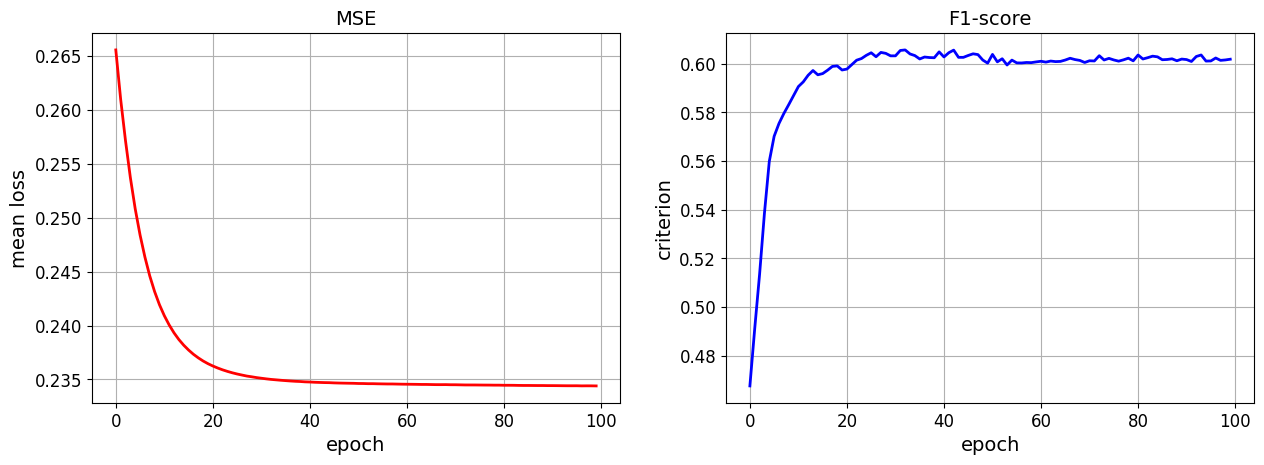

In [30]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 100,
    'lr' : 1e-5,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)
my_device = torch.device('cuda:0')

common_model = BaseCNN(250, 1)
loss, acc, total_time = train_model(common_model, all_dataloader, criterion, learning_params, device=my_device)
print('accuracy: ', acc['Accuracy'][-1])
print('f1-score: ', acc['F1-score'][-1])
print(f'{subj} accuracy CI: [{round(acc["Min Accuracy"][-1], 3)}, {round(acc["Max Accuracy"][-1], 3)}]')
show_progress(loss, acc, 'MSE', 'F1-score')

In [31]:
dataloaders = dict()
for subj in data.keys():
    train_data, val_data, train_labels, val_labels = train_test_split(
        data[subj], 
        labels[subj], 
        test_size=0.15,
        shuffle=False
    )
    train_dataset = CNNMatrixDataset(tensors=(train_data, train_labels), with_target=True, transform=None)
    val_dataset = CNNMatrixDataset(tensors=(val_data, val_labels), with_target=True, transform=None)
    temp_dataloaders = dict()
    temp_dataloaders['train'] = DataLoader(train_dataset, batch_size=1024, shuffle=True)
    temp_dataloaders['val'] = DataLoader(val_dataset, batch_size=1024, shuffle=True)
    dataloaders[subj] = temp_dataloaders

Common model metrics:
S1901 accuracy:  tensor(0.7346, dtype=torch.float64)
S1901 f1-score:  tensor(0.7636, device='cuda:0', dtype=torch.float64)
S1901 accuracy CI: [0.715, 0.754]
Training complete in 2m 43s

Specific model metrics:
S1901 accuracy:  0.8121149897330596
S1901 f1-score:  0.8091762252346195
S1901 accuracy CI: [0.795, 0.829]


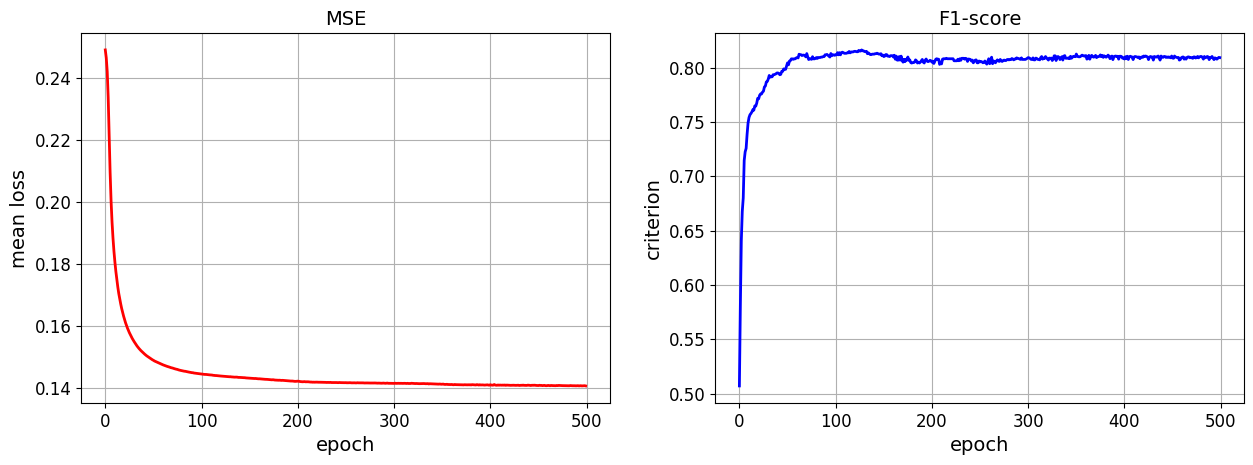

Common model metrics:
S1601 accuracy:  tensor(0.6530, dtype=torch.float64)
S1601 f1-score:  tensor(0.6715, device='cuda:0', dtype=torch.float64)
S1601 accuracy CI: [0.632, 0.674]
Training complete in 2m 43s

Specific model metrics:
S1601 accuracy:  0.7181724845995894
S1601 f1-score:  0.7270014917951267
S1601 accuracy CI: [0.698, 0.738]


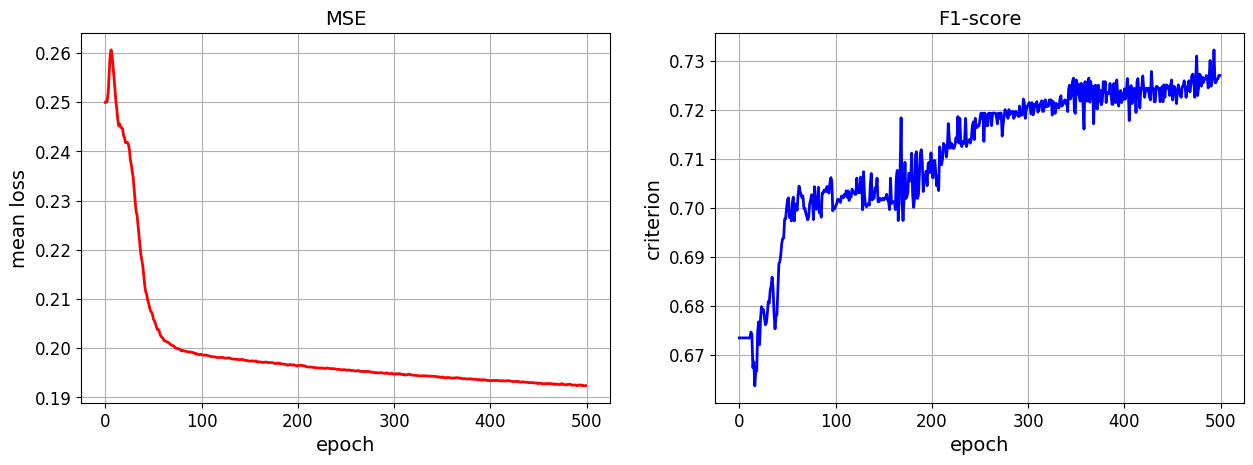

Common model metrics:
S0701 accuracy:  tensor(0.5616, dtype=torch.float64)
S0701 f1-score:  tensor(0.5524, device='cuda:0', dtype=torch.float64)
S0701 accuracy CI: [0.54, 0.584]
Training complete in 2m 45s

Specific model metrics:
S0701 accuracy:  0.6134496919917864
S0701 f1-score:  0.642958748221906
S0701 accuracy CI: [0.592, 0.635]


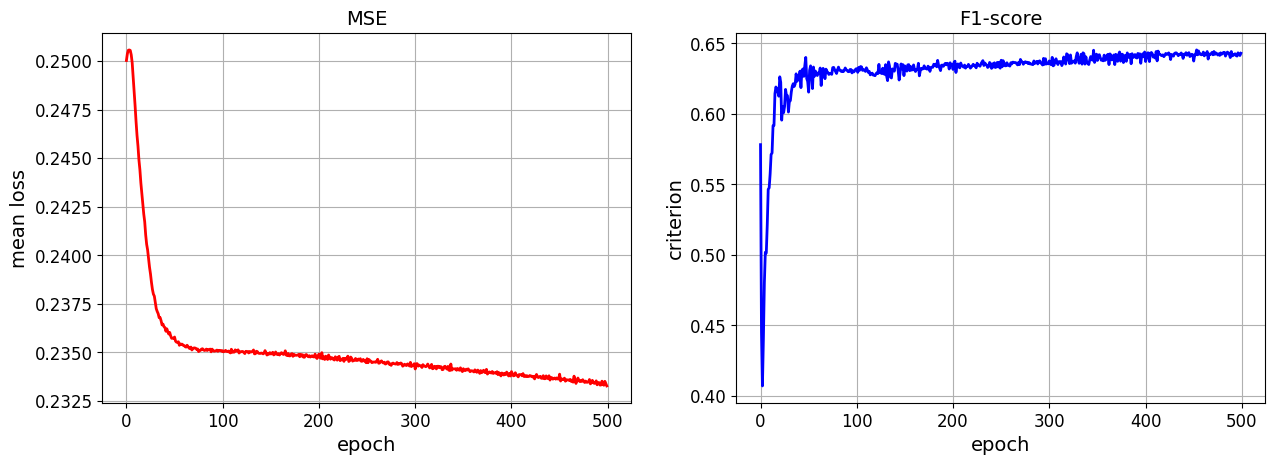

Common model metrics:
S1701 accuracy:  tensor(0.6001, dtype=torch.float64)
S1701 f1-score:  tensor(0.6064, device='cuda:0', dtype=torch.float64)
S1701 accuracy CI: [0.578, 0.622]
Training complete in 2m 44s

Specific model metrics:
S1701 accuracy:  0.6683778234086243
S1701 f1-score:  0.6885245901639344
S1701 accuracy CI: [0.647, 0.689]


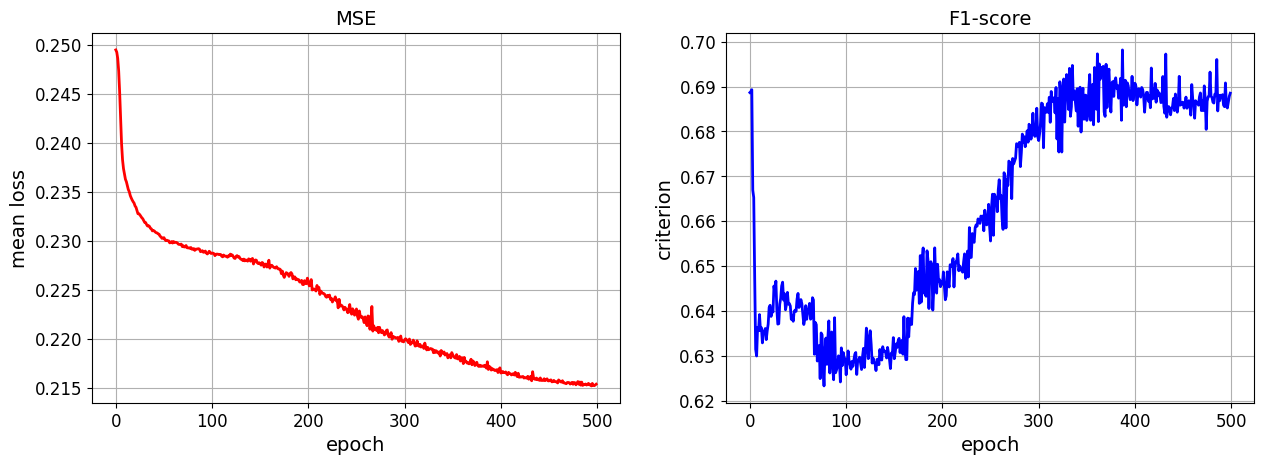

Common model metrics:
S0601 accuracy:  tensor(0.4754, dtype=torch.float64)
S0601 f1-score:  tensor(0.4092, device='cuda:0', dtype=torch.float64)
S0601 accuracy CI: [0.453, 0.498]
Training complete in 2m 44s

Specific model metrics:
S0601 accuracy:  0.6360369609856263
S0601 f1-score:  0.6553232863393291
S0601 accuracy CI: [0.615, 0.657]


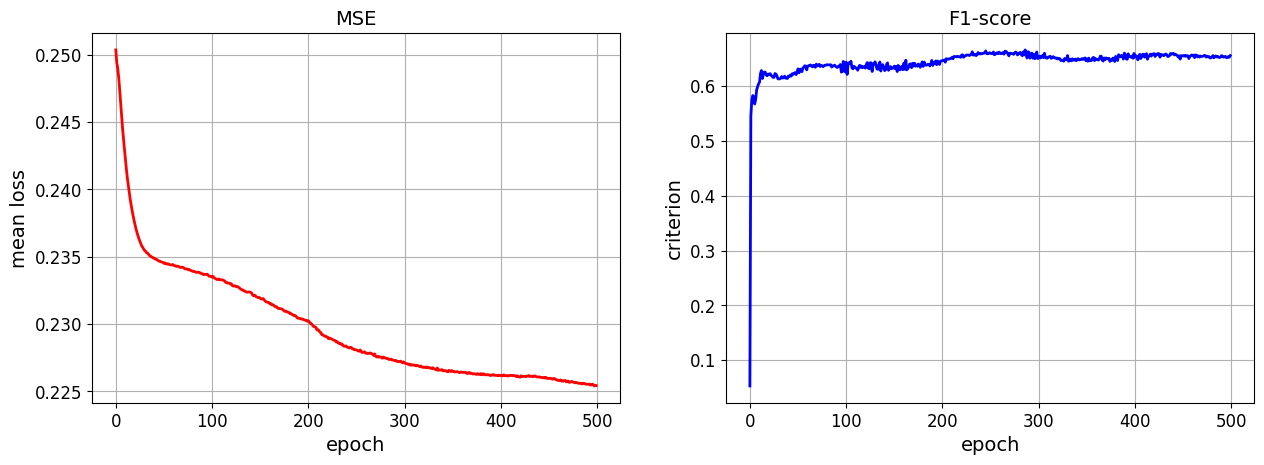

Common model metrics:
S1401 accuracy:  tensor(0.6458, dtype=torch.float64)
S1401 f1-score:  tensor(0.6673, device='cuda:0', dtype=torch.float64)
S1401 accuracy CI: [0.625, 0.667]
Training complete in 2m 45s

Specific model metrics:
S1401 accuracy:  0.7089322381930185
S1401 f1-score:  0.7243558580456976
S1401 accuracy CI: [0.689, 0.729]


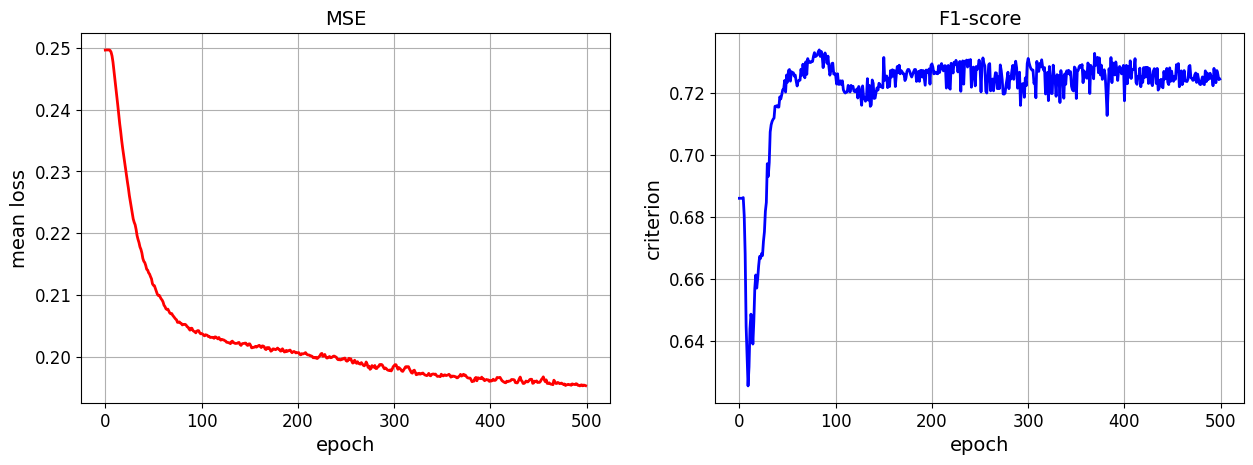

Common model metrics:
S1201 accuracy:  tensor(0.6063, dtype=torch.float64)
S1201 f1-score:  tensor(0.6077, device='cuda:0', dtype=torch.float64)
S1201 accuracy CI: [0.585, 0.628]
Training complete in 2m 45s

Specific model metrics:
S1201 accuracy:  0.6765913757700206
S1201 f1-score:  0.6905697445972494
S1201 accuracy CI: [0.656, 0.697]


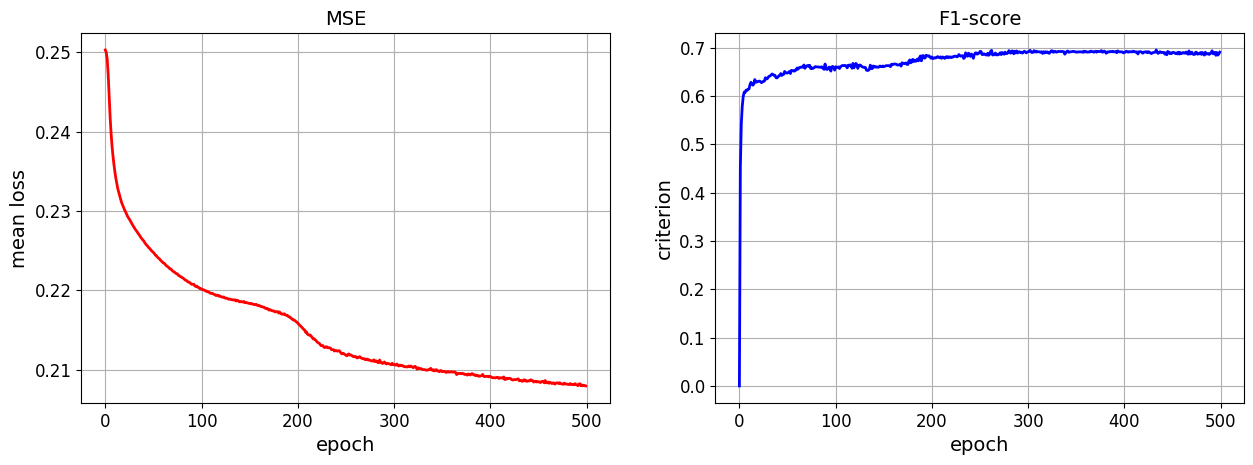

Common model metrics:
S1801 accuracy:  tensor(0.5518, dtype=torch.float64)
S1801 f1-score:  tensor(0.5153, device='cuda:0', dtype=torch.float64)
S1801 accuracy CI: [0.53, 0.574]
Training complete in 2m 46s

Specific model metrics:
S1801 accuracy:  0.654517453798768
S1801 f1-score:  0.6679822397631968
S1801 accuracy CI: [0.633, 0.676]


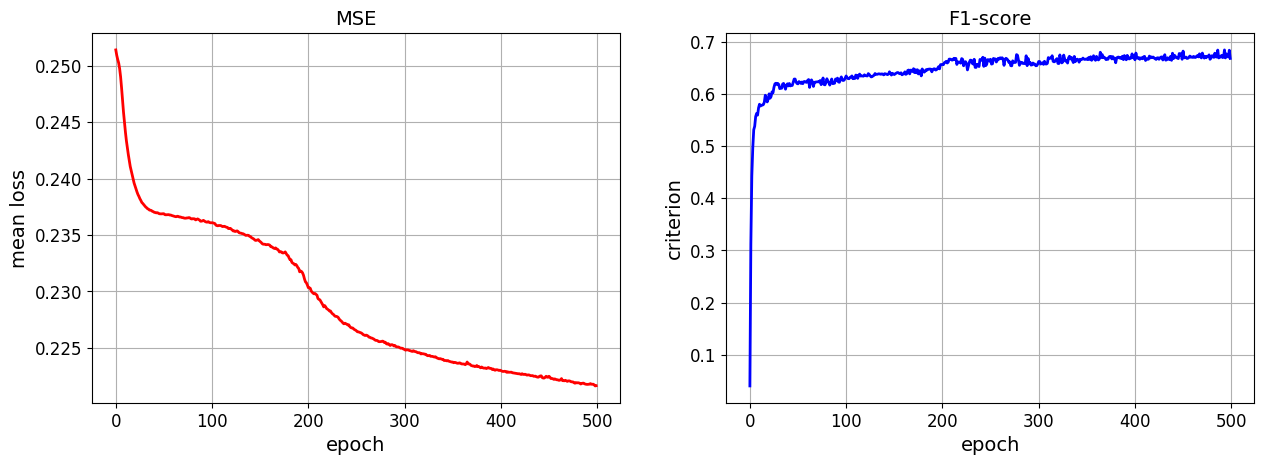

Common model metrics:
S0201 accuracy:  tensor(0.6432, dtype=torch.float64)
S0201 f1-score:  tensor(0.6513, device='cuda:0', dtype=torch.float64)
S0201 accuracy CI: [0.622, 0.664]
Training complete in 2m 46s

Specific model metrics:
S0201 accuracy:  0.667864476386037
S0201 f1-score:  0.6817511067388096
S0201 accuracy CI: [0.647, 0.689]


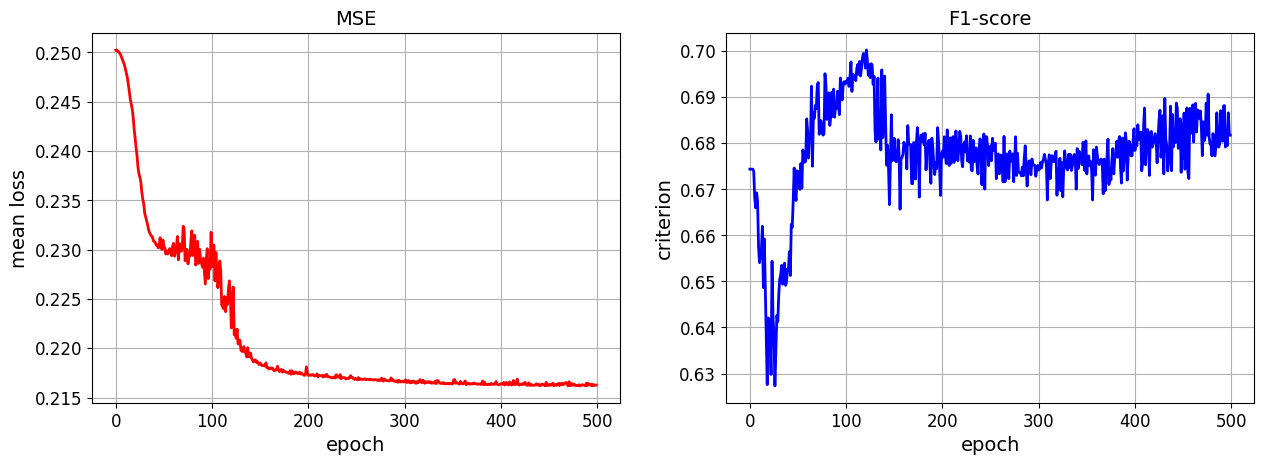

Common model metrics:
S2001 accuracy:  tensor(0.5298, dtype=torch.float64)
S2001 f1-score:  tensor(0.5128, device='cuda:0', dtype=torch.float64)
S2001 accuracy CI: [0.508, 0.552]
Training complete in 2m 45s

Specific model metrics:
S2001 accuracy:  0.6036960985626284
S2001 f1-score:  0.6116700201207242
S2001 accuracy CI: [0.582, 0.625]


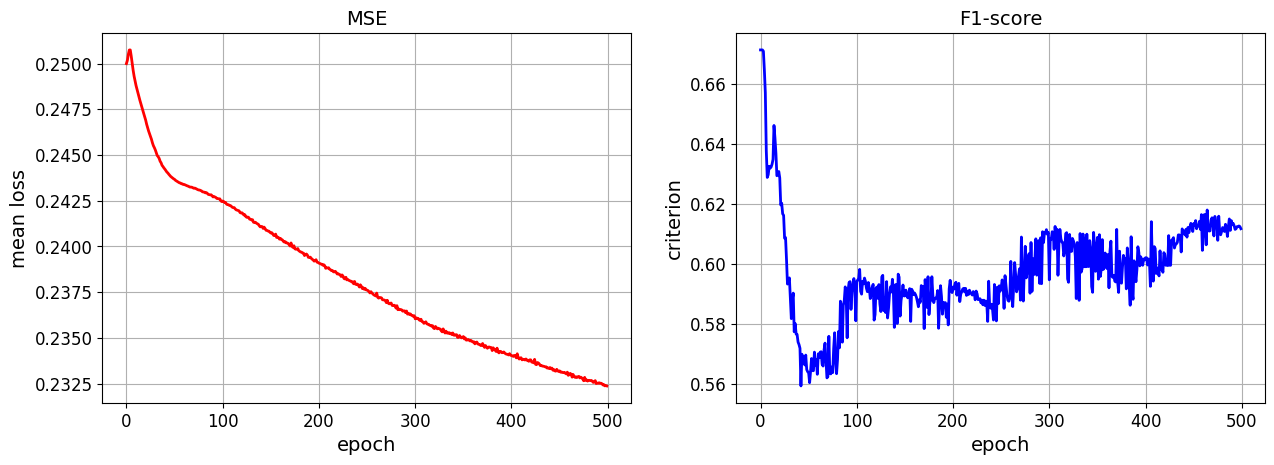

In [39]:
criterion = nn.MSELoss()

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)
my_device = torch.device('cuda:0')

result_sep = dict()
single_models = dict()
for subj, dataloader in dataloaders.items():
    common_acc = validate_model(common_model, dataloader['val'], device=my_device)
    print('Common model metrics:')
    print(f'{subj} accuracy: ', common_acc['Accuracy'])
    print(f'{subj} f1-score: ', common_acc['F1-score'])
    print(f'{subj} accuracy CI: [{round(common_acc["Min Accuracy"], 3)}, {round(common_acc["Max Accuracy"], 3)}]')
    single_models[subj] = BaseCNN(250, 1)
    loss, acc, total_time = train_model(single_models[subj], dataloader, criterion, learning_params, device=my_device)
    print()
    print('Specific model metrics:')
    print(f'{subj} accuracy: ', acc['Accuracy'][-1])
    print(f'{subj} f1-score: ', acc['F1-score'][-1])
    print(f'{subj} accuracy CI: [{round(acc["Min Accuracy"][-1], 3)}, {round(acc["Max Accuracy"][-1], 3)}]')
    show_progress(loss, acc, 'MSE', 'F1-score')
    result_sep[subj] = {'accuracy': acc['Accuracy'][-1], 
                        'f1-score': acc['F1-score'][-1],
                        'size': len(dataloader['val'].dataset),
                        'lower_ci': acc['Min Accuracy'][-1],
                        'upper_ci': acc['Max Accuracy'][-1]}

In [40]:
sum([value['accuracy'] * value['size'] for value in result_sep.values()]) / sum([value['size'] for value in result_sep.values()])

0.6759753593429159

In [42]:
min_pos_train, min_neg_train = 10000, 10000
min_pos_val, min_neg_val = 10000, 10000
for subj in data.keys():
    train_data, val_data, train_labels, val_labels = train_test_split(
        data[subj], 
        labels[subj], 
        test_size=0.15,
        shuffle=False
    )

    min_pos_train = min(min_pos_train, (train_labels == 1).sum())
    min_neg_train = min(min_neg_train, (train_labels == 0).sum())
    min_pos_val = min(min_pos_val, (val_labels == 1).sum())
    min_neg_val = min(min_neg_val, (val_labels == 0).sum())

result_pos_train, result_neg_train = [], []
result_pos_val, result_neg_val = [], []
for subj in data.keys():
    train_data, val_data, train_labels, val_labels = train_test_split(
        data[subj], 
        labels[subj], 
        test_size=0.15,
        shuffle=False
    )

    result_pos_train.append(train_data[train_labels == 1][:min_pos_train][torch.randperm(min_pos_train)])
    result_neg_train.append(train_data[train_labels == 0][:min_neg_train][torch.randperm(min_neg_train)])
    result_pos_val.append(train_data[train_labels == 1][:min_pos_val][torch.randperm(min_pos_val)])
    result_neg_val.append(train_data[train_labels == 0][:min_neg_val][torch.randperm(min_neg_val)])

In [43]:
train_data = torch.cat([torch.cat(result_pos_train, 1), torch.cat(result_neg_train, 1)], 0)
val_data = torch.cat([torch.cat(result_pos_val, 1), torch.cat(result_neg_val, 1)], 0)
train_labels = torch.cat([torch.ones(min_pos_train, dtype=torch.float64), torch.zeros(min_neg_train, dtype=torch.float64)])
val_labels = torch.cat([torch.ones(min_pos_val, dtype=torch.float64), torch.zeros(min_neg_val, dtype=torch.float64)])

train_dataset = CNNMatrixDataset(tensors=(train_data, train_labels), with_target=True, transform=None)
val_dataset = CNNMatrixDataset(tensors=(val_data, val_labels), with_target=True, transform=None)
all_dataloader = dict()
all_dataloader['train'] = DataLoader(train_dataset, batch_size=1024, shuffle=True)
all_dataloader['val'] = DataLoader(val_dataset, batch_size=1024, shuffle=True)

Training complete in 3m 9s
accuracy:  0.8470403352540598
f1-score:  0.8502564102564103


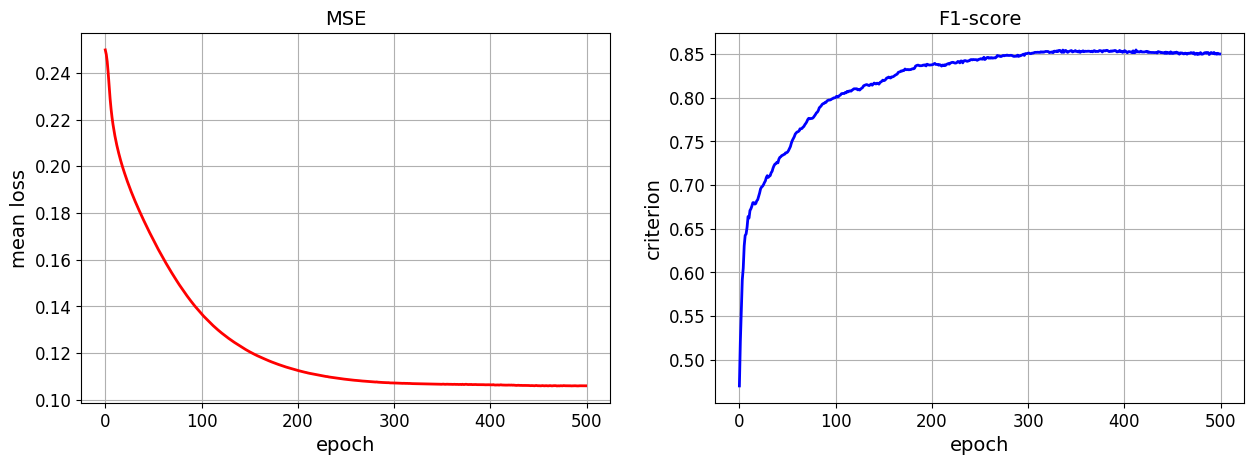

In [55]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)
my_device = torch.device('cuda:0')

mc_model = BaseCNN(250, 10)
loss, acc, total_time = train_model(mc_model, all_dataloader, criterion, learning_params, device=my_device)
print('accuracy: ', acc['Accuracy'][-1])
print('f1-score: ', acc['F1-score'][-1])
show_progress(loss, acc, 'MSE', 'F1-score')

In [98]:
val_all_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

mc_preds = infer_model(mc_model, val_all_dataloader, device=my_device)[:, 1]

single_model_preds = []
common_model_preds = []
for i, subj in enumerate(data.keys()):
    single_model_preds.append(infer_model(single_models[subj], val_all_dataloader, channel=i, device=my_device)[:, 1])
    common_model_preds.append(infer_model(common_model, val_all_dataloader, channel=i, device=my_device)[:, 1])

In [105]:
labels = torch.cat([data[1] for data in val_all_dataloader])[:, 1]

In [112]:
soft_single = (torch.stack(single_model_preds).T.mean(dim=1) > 0.5).float()
hard_single = ((torch.stack(single_model_preds).T > 0.5).sum(dim=1) > 5).float()

soft_common = (torch.stack(common_model_preds).T.mean(dim=1) > 0.5).float()
hard_common = ((torch.stack(common_model_preds).T > 0.5).sum(dim=1) > 5).float()

single_model = []
for preds in single_model_preds:
    single_model.append((preds > 0.5).float())

mc = (mc_preds > 0.5).float()

In [129]:
all_predictions = [soft_single, hard_single, mc, soft_common, hard_common]
predictions_names = ['different models [soft voting]',
                     'different models [hard voting]',
                     'multi channel model           ',
                     'one common model [soft voting]',
                     'one common model [hard voting]']

print('model type                    CI lower CI upper')
for preds, title in zip(all_predictions, predictions_names):
    min_acc, max_acc = proportion_confint(sum(preds == labels), len(val_all_dataloader.dataset), 0.05)
    print(title, round(min_acc, 3), round(max_acc, 3), sep='\t')

for preds, subj in zip(single_model, data.keys()):
    min_acc, max_acc = proportion_confint(sum(preds == labels), len(val_all_dataloader.dataset), 0.05)
    print(f'solo {subj} model performance', round(min_acc, 3), round(max_acc, 3), sep='\t')

model type                    CI lower CI upper
different models [soft voting]	0.921	0.944
different models [hard voting]	0.875	0.904
multi channel model           	0.831	0.863
one common model [soft voting]	0.777	0.813
one common model [hard voting]	0.697	0.738
solo S1901 model performance	0.792	0.827
solo S1601 model performance	0.694	0.735
solo S0701 model performance	0.612	0.655
solo S1701 model performance	0.622	0.665
solo S0601 model performance	0.619	0.662
solo S1401 model performance	0.681	0.722
solo S1201 model performance	0.678	0.719
solo S1801 model performance	0.641	0.683
solo S0201 model performance	0.663	0.704
solo S2001 model performance	0.594	0.637


* Лучше всего работает усреднение разных моделей

* Общая модель на 10 каналов стат значимо хуже усреднения одиночных

* Использование же общей модели для каждого канала работает хуже, чем лучшая из одиночных моделей